# AutoEncoders

## Motivating the Autoencoder Architecture

When we talked about feed-forward networks, we discussed how each layer learned progressively more relevant representations of the input. Putting aside the fact that we want to generate these low-dimensional representations in an unsupervised fashion, there are fundamental problems with these approaches in general. Specifically, while the selected layer does contain information from the input, the network has been trained to pay attention to the aspects of the input that are critical to solving the task at hand. As a result, there’s a significant amount of information loss with respect to elements of the input that may be important for other classification tasks, but potentially less important than the one immediately at hand. 

However, the fundamental intuition here still applies. We define a new network architecture that we call the autoencoder. We first take the input and compress it into a low-dimensional vector. This part of the network is called the encoder because it is responsible for producing the low-dimensional embedding or code. The second part of the network, instead of mapping the embedding to an arbitrary label as we would in a feed-forward network, tries to invert the computation of the first half of the network and reconstruct the original input. This piece is known as the decoder.

<img src='images/img4.png'>

## Implementing an Autoencoder in Tensorflow

The seminal paper “Reducing the dimensionality of data with neural networks,” which describes the autoencoder, was written by Hinton and Salakhutdinov in 2006.1 Their hypothesis was that the nonlinear complexities afforded by a neural model would allow them to capture structure that linear methods, such as PCA, would miss. To demonstrate this point, they ran an experiment on MNIST using both an autoencoder and PCA to reduce the dataset into two-dimensional data points. In this section,  we will recreate their experimental setup to validate this hypothesis and further explore the architecture and properties of feed-forward autoencoders.

<img src='images/img5.png'>

The setup shown in above figure is built with the same principle, but the twodimensional embedding is now treated as the input, and the network attempts to reconstruct the original image. Because we are essentially applying an inverse operation, we architect the decoder network so that the autoencoder has the shape of an hourglass. The output of the decoder network is a 784-dimensional vector  that can be reconstructed into a 28 × 28 image:

In [8]:
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
from tensorflow.examples.tutorials.mnist import input_data

In [9]:
def encoder(x, n_code, phase_train):

    with tf.variable_scope("encoder"):

        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(x, [784, n_encoder_hidden_1], [n_encoder_hidden_1], phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_encoder_hidden_1, n_encoder_hidden_2], [n_encoder_hidden_2], phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_encoder_hidden_2, n_encoder_hidden_3], [n_encoder_hidden_3], phase_train)
        with tf.variable_scope("code"):
            code = layer(hidden_3, [n_encoder_hidden_3, n_code], [n_code], phase_train)
    return code

def decoder(code,n_code,phase_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden_1"):
            hidden_1=layer(code,[n_code,n_decoder_hidden_1],[n_decoder_hidden_1],phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2=layer(hidden_1,[n_decoder_hidden_1,n_decoder_hidden_2],[n_decoder_hidden_2],phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3=layer(hidden_2,[n_decoder_hidden_2,n_decoder_hidden_3],[n_decoder_hidden_3],phase_train)
        with tf.variable_scope("output"):
            output=layer(hidden_3,[n_decoder_hidden_3,784],[784],phase_train)
        return output
    
def layer(input,weight_shape, bias_shape, phase_train):
    weight_init=tf.random_normal_initializer(stddev=(1.0/weight_shape[0])**0.5)
    bias_init=tf.constant_initializer(value=0)
    W=tf.get_variable("W",weight_shape,initializer=weight_init)
    b=tf.get_variable("b",bias_shape,initializer=bias_init)
    logits=tf.matmul(input,W)+b
    return tf.nn.sigmoid(layer_batch_norm(logits,weight_shape[1],phase_train))


def layer_batch_norm(x,n_out,phase_train):
    beta_init=tf.constant_initializer(value=0.0,dtype=tf.float32)
    gamma_init=tf.constant_initializer(value=1.0,dtype=tf.float32)
    beta=tf.get_variable("beta",[n_out],initializer=beta_init)
    gamma=tf.get_variable("gamma",[n_out],initializer=gamma_init)
    batch_mean,batch_var=tf.nn.moments(x,[0],name='moments')
    ema=tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op=ema.apply([batch_mean,batch_var])
    ema_mean,ema_var=ema.average(batch_mean),ema.average(batch_var)
    
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean),tf.identity(batch_var)
    mean,var=control_flow_ops.cond(phase_train,mean_var_with_update,lambda:(ema_mean,ema_var))
    normed=tf.nn.batch_norm_with_global_normalization(x,mean,var,beta,gamma,1e-3,True)
    return normed

Finally, we need to construct a measure (or objective function) that describes how well our model functions. Specifically, we want to measure how close the reconstruction is to the original image. We can measure this simply by computing the distance between the original 784-dimensional input and the reconstructed 784-dimensional output.  More specifically, given an input vector I and a reconstruction O, we’d like to minimize the value of
$$ ||I-O|| = \sqrt{\sum_i{(I_i-O_i)}^2} $$
also known as the L2 norm of the difference between the two vectors. We average this function over the whole minibatch to generate our final objective function. Finally, we’ll train the network using the Adam optimizer, logging a scalar summary of the error incurred at every minibatch using tf.scalar_summary. In TensorFlow, we can concisely express the loss and training operations as follows:


In [21]:
def loss(output,x):
    with tf.variable_scope("training"):
        l2=tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output,x)),1))
        train_loss=tf.reduce_mean(l2)
        train_summary_op=tf.summary.scalar("train_cost",train_loss)
        return train_loss,train_summary_op

def training(cost,global_step):
    optimizer=tf.train.AdamOptimizer(learning_rate=0.01,beta1=0.9,beta2=0.999,epsilon=1e-08,use_locking=False,name="Adam")
    train_op=optimizer.minimize(cost,global_step=global_step)
    return train_op

def image_summary(summary_label,tensor):
    tensor_reshaped=tf.reshape(tensor,[-1,28,28,1])
    return tf.summary.image(summary_label,tensor_reshaped)

def evaluate(output,x):
    with tf.variable_scope("validation"):
        in_im_op=image_summary("input_image",x)
        out_im_op=image_summary("output_image",output)
        l2=tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(output,x,name='val_diff')),1))
        val_loss=tf.reduce_mean(l2)
        val_summary_op=tf.summary.scalar("val_cost",val_loss)
        return val_loss,in_im_op,out_im_op,val_summary_op

Finally, all that’s left to do is build the model out of these subcomponents and train the model. A lot of this code is familiar, but it has a couple of additional bells and whistles that are worth covering. First, we have modified our usual code to accept a command-line parameter for determining the number of neurons in our code layer. For example, running $ python autoencoder_mnist.py 2 will instantiate a model with two neurons in the code layer. We also reconfigure the model saver to maintain more snapshots of our model. We’ll be reloading our most effective model later to compare its performance to PCA, so we’d like to be able to have access to many snapshots. We use summary writers to also capture the image summaries we generate at the end of each epoch:

In [25]:

n_encoder_hidden_1 = 1000
n_encoder_hidden_2 = 500
n_encoder_hidden_3 = 250
n_decoder_hidden_1 = 250
n_decoder_hidden_2 = 500
n_decoder_hidden_3 = 1000

# Parameters

learning_rate = 0.01
training_epochs = 1000
batch_size = 100
display_step = 1
n_code="1"

mnist=input_data.read_data_sets("data/",one_hot=True)
with tf.Graph().as_default():
    with tf.variable_scope("autoencoder_model"):
        x=tf.placeholder("float",[None,784])
        phase_train=tf.placeholder(tf.bool)
        code=encoder(x,int(n_code),phase_train)
        output=decoder(code,int(n_code),phase_train)
        cost,train_summary_op=loss(output,x)
        global_step=tf.Variable(0,name='global_step',trainable=False)
        train_op=training(cost,global_step=global_step)
        eval_op,in_im_op,out_im_op,val_summary_op=evaluate(output,x)
        summary_op=tf.summary.merge_all()
        saver=tf.train.Saver(max_to_keep=200)
        sess=tf.Session()
        train_writer=tf.summary.FileWriter("mnist_autoencoder_hidden="+n_code+"_logs/",graph=sess.graph)
        val_writer=tf.summary.FileWriter("mnist_autoencoder_hidden="+n_code+"_logs/",graph=sess.graph)
        init_op=tf.initialize_all_variables()
        sess.run(init_op)
        
        for epoch in range(training_epochs):
            avg_cost=0
            total_batch=int(mnist.train.num_examples/batch_size)
            #loop over all batchs
            for i in range(total_batch):
                mbatch_x,mbatch_y=mnist.train.next_batch(batch_size)
                # fit training using batch data
                _, new_cost, train_summary = sess.run([train_op, cost, train_summary_op], feed_dict={x: mbatch_x, phase_train: True})
                train_writer.add_summary(train_summary,sess.run(global_step))
                #compute avg loss
                avg_cost+=new_cost/total_batch
            # Display loss per epoch step
            if epoch%display_step==0:
                print("Epoch: ",'%04d'%(epoch+1),"cost =","{:.9f}".format(avg_cost))
                train_writer.add_summary(train_summary,sess.run(global_step))
                val_images=mnist.validation.images
                validation_loss,in_im,out_im,val_summary=sess.run([eval_op,in_im_op,out_im_op,val_summary_op],feed_dict={x:mnist.validation.images,phase_train:True})
                val_writer.add_summary(in_im,sess.run(global_step))
                val_writer.add_summary(out_im,sess.run(global_step))
                val_writer.add_summary(val_summary,sess.run(global_step))
                print("Validation loss: ",validation_loss)
                saver.save(sess,"mnist_autoencoder_hidden="+n_code+"_logs/model_checkpoint-"+'%04d'%(epoch+1),global_step=global_step)
                
        print("Optimization finished!")
        
        test_loss=sess.run(eval_op,feed_dict={x:mnist.test.images,phase_train:False})
        print("Test Loss: ",test_loss)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Epoch:  0001 cost = 7.999153629
Validation loss:  6.6351423
Epoch:  0002 cost = 6.537048624
Validation loss:  6.391499
Epoch:  0003 cost = 6.352392913
Validation loss:  6.16795
Epoch:  0004 cost = 6.206686269
Validation loss:  6.0317855
Epoch:  0005 cost = 6.125459082
Validation loss:  6.0164623
Epoch:  0006 cost = 6.069574726
Validation loss:  5.9600644
Epoch:  0007 cost = 6.013291869
Validation loss:  5.882925
Epoch:  0008 cost = 5.982091157
Validation loss:  5.878444
Epoch:  0009 cost = 5.970386131
Validation loss:  5.8715787
Epoch:  0010 cost = 5.933869539
Validation loss:  5.829715
Epoch:  0011 cost = 5.922310389
Validation loss:  5.797016
Epoch:  0012 cost = 5.895324387
Validation loss:  5.816644
Epoch:  0013 cost = 5.888214655
Validation loss:  5.761907
Epoch:  0014 cost = 5.868229993
Validation loss:  5.7358966

Epoch:  0136 cost = 5.597986068
Validation loss:  5.4814205
Epoch:  0137 cost = 5.598379676
Validation loss:  5.5555706
Epoch:  0138 cost = 5.585494450
Validation loss:  5.4714937
Epoch:  0139 cost = 5.584126611
Validation loss:  5.455359
Epoch:  0140 cost = 5.572630570
Validation loss:  5.4442677
Epoch:  0141 cost = 5.577249275
Validation loss:  5.4503584
Epoch:  0142 cost = 5.576811269
Validation loss:  5.446489
Epoch:  0143 cost = 5.575583943
Validation loss:  5.4643135
Epoch:  0144 cost = 5.569939688
Validation loss:  5.4523425
Epoch:  0145 cost = 5.577859045
Validation loss:  5.45386
Epoch:  0146 cost = 5.557352098
Validation loss:  5.441768
Epoch:  0147 cost = 5.558429506
Validation loss:  5.445495
Epoch:  0148 cost = 5.566612889
Validation loss:  5.4554725
Epoch:  0149 cost = 5.562831919
Validation loss:  5.4692063
Epoch:  0150 cost = 5.565977473
Validation loss:  5.462494
Epoch:  0151 cost = 5.567608116
Validation loss:  5.4646244
Epoch:  0152 cost = 5.564578681
Validation loss

Epoch:  0274 cost = 5.527370068
Validation loss:  5.437241
Epoch:  0275 cost = 5.527399062
Validation loss:  5.4014482
Epoch:  0276 cost = 5.527395100
Validation loss:  5.43152
Epoch:  0277 cost = 5.529826906
Validation loss:  5.435843
Epoch:  0278 cost = 5.513572279
Validation loss:  5.395786
Epoch:  0279 cost = 5.513888815
Validation loss:  5.3820076
Epoch:  0280 cost = 5.503813575
Validation loss:  5.3845787
Epoch:  0281 cost = 5.504328482
Validation loss:  5.396221
Epoch:  0282 cost = 5.511629189
Validation loss:  5.3948307
Epoch:  0283 cost = 5.513192485
Validation loss:  5.3922215
Epoch:  0284 cost = 5.497397471
Validation loss:  5.3702273
Epoch:  0285 cost = 5.499652390
Validation loss:  5.379018
Epoch:  0286 cost = 5.523483204
Validation loss:  5.4058657
Epoch:  0287 cost = 5.526093799
Validation loss:  5.388698
Epoch:  0288 cost = 5.514292289
Validation loss:  5.3971605
Epoch:  0289 cost = 5.514167167
Validation loss:  5.394954
Epoch:  0290 cost = 5.512693546
Validation loss: 

Epoch:  0412 cost = 5.562698414
Validation loss:  5.421468
Epoch:  0413 cost = 5.571541421
Validation loss:  5.4490705
Epoch:  0414 cost = 5.572118237
Validation loss:  5.4601884
Epoch:  0415 cost = 5.589469918
Validation loss:  5.477304
Epoch:  0416 cost = 5.593666837
Validation loss:  5.483932
Epoch:  0417 cost = 5.583649304
Validation loss:  5.454245
Epoch:  0418 cost = 5.585157546
Validation loss:  5.4591274
Epoch:  0419 cost = 5.563256501
Validation loss:  5.449321
Epoch:  0420 cost = 5.568848973
Validation loss:  5.488666
Epoch:  0421 cost = 5.577602117
Validation loss:  5.47814
Epoch:  0422 cost = 5.580490100
Validation loss:  5.4740086
Epoch:  0423 cost = 5.563504219
Validation loss:  5.468345
Epoch:  0424 cost = 5.575361625
Validation loss:  5.4620485
Epoch:  0425 cost = 5.600217390
Validation loss:  5.497427
Epoch:  0426 cost = 5.611030358
Validation loss:  5.478809
Epoch:  0427 cost = 5.627708687
Validation loss:  5.5104356
Epoch:  0428 cost = 5.616979778
Validation loss:  5

Epoch:  0550 cost = 5.539002511
Validation loss:  5.4361086
Epoch:  0551 cost = 5.530090549
Validation loss:  5.3898163
Epoch:  0552 cost = 5.540459162
Validation loss:  5.40597
Epoch:  0553 cost = 5.532945753
Validation loss:  5.4167023
Epoch:  0554 cost = 5.525660086
Validation loss:  5.40845
Epoch:  0555 cost = 5.529677079
Validation loss:  5.3952146
Epoch:  0556 cost = 5.527012585
Validation loss:  5.3872533
Epoch:  0557 cost = 5.522904992
Validation loss:  5.397342
Epoch:  0558 cost = 5.518370466
Validation loss:  5.390886
Epoch:  0559 cost = 5.522595458
Validation loss:  5.4114914
Epoch:  0560 cost = 5.519866424
Validation loss:  5.3958826
Epoch:  0561 cost = 5.528275011
Validation loss:  5.3947873
Epoch:  0562 cost = 5.516336940
Validation loss:  5.4084644
Epoch:  0563 cost = 5.522072385
Validation loss:  5.394656
Epoch:  0564 cost = 5.513227560
Validation loss:  5.3995047
Epoch:  0565 cost = 5.521970153
Validation loss:  5.398073
Epoch:  0566 cost = 5.523283607
Validation loss:

Epoch:  0688 cost = 5.455474104
Validation loss:  5.3233337
Epoch:  0689 cost = 5.459098597
Validation loss:  5.343059
Epoch:  0690 cost = 5.474467553
Validation loss:  5.3358
Epoch:  0691 cost = 5.458653343
Validation loss:  5.345341
Epoch:  0692 cost = 5.479589820
Validation loss:  5.35022
Epoch:  0693 cost = 5.477026122
Validation loss:  5.360072
Epoch:  0694 cost = 5.495363763
Validation loss:  5.362425
Epoch:  0695 cost = 5.487142963
Validation loss:  5.3606176
Epoch:  0696 cost = 5.490068798
Validation loss:  5.3753343
Epoch:  0697 cost = 5.494787436
Validation loss:  5.355015
Epoch:  0698 cost = 5.484972690
Validation loss:  5.3417807
Epoch:  0699 cost = 5.483044049
Validation loss:  5.3507037
Epoch:  0700 cost = 5.485639000
Validation loss:  5.3638697
Epoch:  0701 cost = 5.486883867
Validation loss:  5.33908
Epoch:  0702 cost = 5.485267832
Validation loss:  5.355208
Epoch:  0703 cost = 5.496616070
Validation loss:  5.361781
Epoch:  0704 cost = 5.489639239
Validation loss:  5.35

Epoch:  0826 cost = 5.507979580
Validation loss:  5.377641
Epoch:  0827 cost = 5.512255728
Validation loss:  5.380063
Epoch:  0828 cost = 5.513360538
Validation loss:  5.373489
Epoch:  0829 cost = 5.510569992
Validation loss:  5.4197164
Epoch:  0830 cost = 5.520206678
Validation loss:  5.4011736
Epoch:  0831 cost = 5.521806694
Validation loss:  5.40133
Epoch:  0832 cost = 5.511810845
Validation loss:  5.373845
Epoch:  0833 cost = 5.508045006
Validation loss:  5.3781023
Epoch:  0834 cost = 5.514959358
Validation loss:  5.393273
Epoch:  0835 cost = 5.517250887
Validation loss:  5.365475
Epoch:  0836 cost = 5.502417965
Validation loss:  5.372471
Epoch:  0837 cost = 5.495907337
Validation loss:  5.364214
Epoch:  0838 cost = 5.494512628
Validation loss:  5.3637533
Epoch:  0839 cost = 5.501507345
Validation loss:  5.375939
Epoch:  0840 cost = 5.495315729
Validation loss:  5.350961
Epoch:  0841 cost = 5.480537015
Validation loss:  5.378355
Epoch:  0842 cost = 5.485127133
Validation loss:  5.3

Epoch:  0964 cost = 5.443313124
Validation loss:  5.317585
Epoch:  0965 cost = 5.446958086
Validation loss:  5.3275347
Epoch:  0966 cost = 5.455521709
Validation loss:  5.331829
Epoch:  0967 cost = 5.455851415
Validation loss:  5.338665
Epoch:  0968 cost = 5.452307941
Validation loss:  5.3407326
Epoch:  0969 cost = 5.441920595
Validation loss:  5.3241773
Epoch:  0970 cost = 5.452166563
Validation loss:  5.326715
Epoch:  0971 cost = 5.446931054
Validation loss:  5.313835
Epoch:  0972 cost = 5.455862946
Validation loss:  5.3420744
Epoch:  0973 cost = 5.468980421
Validation loss:  5.3342037
Epoch:  0974 cost = 5.460151136
Validation loss:  5.3297076
Epoch:  0975 cost = 5.466823470
Validation loss:  5.340048
Epoch:  0976 cost = 5.458830501
Validation loss:  5.3269854
Epoch:  0977 cost = 5.452529240
Validation loss:  5.3259635
Epoch:  0978 cost = 5.445494284
Validation loss:  5.3084474
Epoch:  0979 cost = 5.443872127
Validation loss:  5.310445
Epoch:  0980 cost = 5.455913763
Validation loss

<img src='images/img6.png'>

Thanks to how we’ve namespaced the components of our TensorFlow graph, our model is nicely organized. We can easily click through the components and delve deeper, tracing how data flows up through the various layers of the encoder and through the decoder, how the optimizer reads the output of our training module, and how gradients in turn affect all of the components of the model.

We also visualize both the training (after each minibatch) and validation costs (after each epoch), closely monitoring the curves for potential overfitting. The TensorBoard visualizations of the costs over the span of training are shown in Figure above. As we would expect for a successful model, both the training and validation curves decrease until they flatten off asymptotically. After approximately 200 epochs, we attain a validation cost of 4.78. While the curves look promising, it’s difficult to, upon first glance, understand whether we’ve reached a plateau at a “good” cost, or whether our model is still doing a poor job of reconstructing the original inputs

<img src='images/img7.png'>

To get a sense of what that means, let’s explore the MNIST dataset. We pick an arbitrary image of a 1 from the dataset and call it X. In Figures below, we compare the image to all other images in the dataset. Specifically, for each digit class, we compute the average of the L2 costs, comparing X to each instance of the digit class. As a visual aide, we also include the average of all of the instances for each digit class.

### Original Inputs
<img src='images/img8.png'>

### Generated Output
<img src='images/img9.png'>

Because we are collecting image summaries, we can confirm this hypothesis directly by inspecting the input images and reconstructions directly. The reconstructions for three randomly chosen samples from the test set are shown in Figure below:

### 2200 steps
<img src='images/img10.png'>

### 13750 steps
<img src='images/img11.png'>

### 43750 steps
<img src='images/img12.png'>

Finally, we’ll complete the section by exploring the two-dimensional codes produced by traditional PCA and autoencoders. We’ll want to show that autoencoders produce better visualizations. In particular, we’ll want to show that autoencoders do a much better job of visually separating instances of different digit classes than PCA. We’ll start by quickly covering the code we use to produce two-dimensional PCA codes:

In [28]:
from sklearn import decomposition

In [29]:
pca=decomposition.PCA(n_components=2)
pca.fit(mnist.train.images)
pca_codes=pca.transform(mnist.test.images)

We first pull up the MNIST dataset. We’ve set the flag one_hot=False because we’d like the labels to be provided as integers instead of one-hot vectors (as a quick reminder, a one-hot vector representing an MNIST label would be a vector of size 10 with the ith component set to one to represent digit i and the rest of the components set to zero). We use the commonly used machine learning library scikit-learn to perform the PCA, setting the n_components=2 flat so that scikit-learn knows to generate two-dimensional codes. We can also reconstruct the original images from the twodimensional codes and visualize the reconstructions:

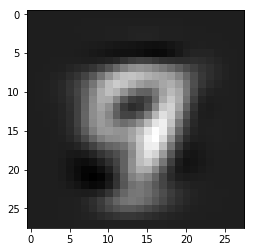

In [33]:
from matplotlib import pyplot as plt

pca_recon=pca.inverse_transform(pca_codes[:1])
plt.imshow(pca_recon[0].reshape((28,28)),cmap=plt.cm.gray)
plt.show()